## 定义问题
#### 背景：
香港棋牌是公司目前最关注的游戏之一，目前也是推广较多的地区，每个新增用户获取都有一定的成本，如何将这些新增用户进行良好的维护，以及探索他们不同的玩牌习惯来进行产品优化，都是非常重要的
#### 具体方案：
对新增7日内的用户进行聚类，然后再对每一类用户进行特征分析。  
## 预选择特征
* 7日玩牌分值play_passion(0~100分，根据用户在所有用户中的排名）
* 7日付费分值pay_passion

额外数据：
* 用户id mid
* fbpid
* 注册日期 signup_date

## 数据获取
为了能够对这些新增用户之后的特征进行分析，我们选取60天之前的新增用户，同时为了避免受到时间干扰，选取10个日期的随机10000个新增用户，然后提取出这些用户在新增7日后的数据

#### 数据提取语句
从新增表取出5月14~5月23日的新增用户，将其保存在内存中，然后关联玩牌和付费中间表
``` sql
WITH a1 AS
  (SELECT fbpid,fuid,dt
    FROM stage_dfqp.user_signup_stg
   WHERE dt >= '2018-05-14'
     AND dt <= '2018-05-23'
     AND fplatformname = '香港'),
a2 AS
  (SELECT fuid,play_passion,pay_passion,dt
    FROM veda.user_label_7day
   WHERE dt >= '2018-05-21'
     AND dt <= '2018-05-30'
     AND fplatformname = '香港')
SELECT a1.fbpid,
       a1.fuid,
       a1.dt AS signup_date,
       a2.play_passion,
       a2.pay_passion
  FROM a1 LEFT JOIN a2
    ON a1.fuid = a2.fuid
   AND date_add(a1.dt,7) = a2.dt
```
## 数据读取

In [72]:
import pandas as pd
import numpy as np
from pandas import Series,DataFrame
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
# 允许多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [73]:
data = pd.read_csv('./query-hive-16105.csv')
data.fillna('0',inplace=True)
#data.head(10)
data['play_passion']=data['play_passion'].astype('int')
data['pay_passion']=data['pay_passion'].astype('int')
#data.dtypes
data.describe()

,fuid,play_passion,pay_passion
count,1.000000e+04,10000.000000,10000.000000
mean,1.002957e+09,23.296200,0.389300
std,5.496236e+03,28.595983,3.499596
min,1.002948e+09,0.000000,0.000000
25%,1.002952e+09,0.000000,0.000000
50%,1.002957e+09,9.000000,0.000000
75%,1.002962e+09,39.000000,0.000000
max,1.002966e+09,100.000000,98.000000


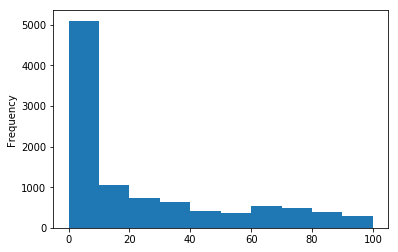

In [21]:
data['play_passion'].plot(kind='hist')

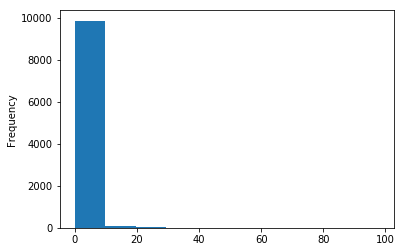

In [19]:
data['pay_passion'].plot(kind='hist')

In [18]:
data.groupby('pay_passion').size()

pay_passion
0     9805
7       35
8       22
10      14
13      16
15       5
16      16
17       8
18       9
19       4
20       2
21       4
22       1
23       4
24       5
25       3
26       5
27       1
28       5
30       1
31       1
32       4
33       1
34       1
36       2
37       1
38       1
40       1
41       1
42       1
43       1
44       2
45       2
46       4
49       1
54       2
56       2
57       1
59       1
60       1
64       1
69       1
82       1
98       1
dtype: int64

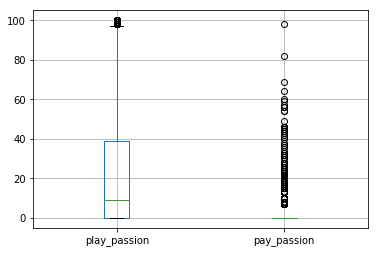

In [5]:
data.iloc[:,3:5].boxplot()

### 数据情况
玩牌的中位数是9，平均数是23，可见是一个右偏分布  
付费的也是右偏,并且分值为0的数据非常多  
虽然离群点会对聚类造成影响，但是分值高的用户对我们非常重要，因此不去除

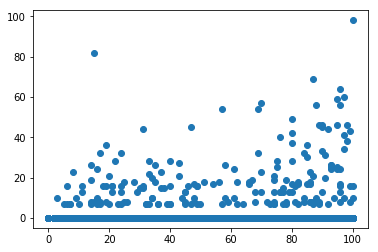

In [74]:
from sklearn.preprocessing import MinMaxScaler
array= data.values
X = array[:,3:5].astype(np.int)
plt.scatter(X[:,0],X[:,1])

## K-means

#### 轮廓系数

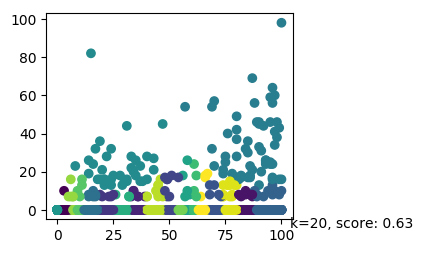

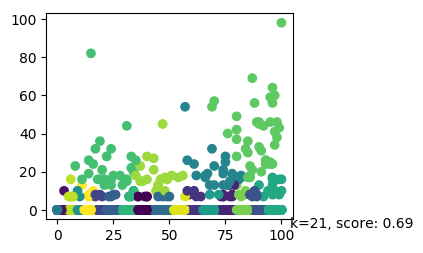

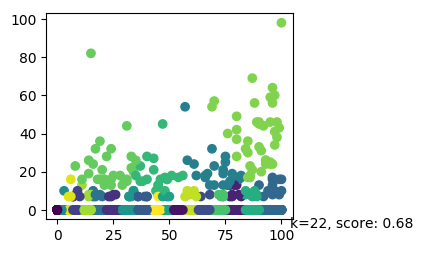

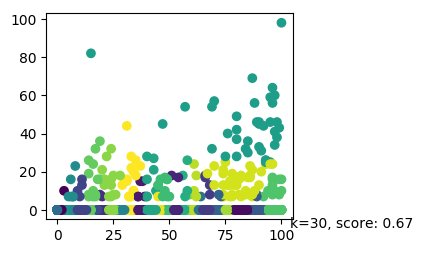

In [8]:
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
for index, k in enumerate((20,21,22,30)):
    fig = plt.figure(figsize=(7,6),dpi=100)
    plt.subplot(2,2,index+1)
    kmeans_model = MiniBatchKMeans(n_clusters=k, batch_size = 200, random_state=9).fit(X)
    y_pred = MiniBatchKMeans(n_clusters=k, batch_size = 200, random_state=9).fit_predict(X)
    labels = kmeans_model.labels_
    score = metrics.silhouette_score(X, labels, metric='euclidean') 
    plt.scatter(X[:, 0], X[:, 1], c=y_pred);
    plt.text(.99, .01, ('k=%d, score: %.2f' % (k,score)),
                 transform=plt.gca().transAxes, size=10,
                 verticalalignment='top')
plt.show();

#### Calinski-Harabaz Index

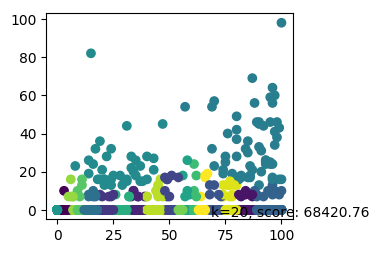

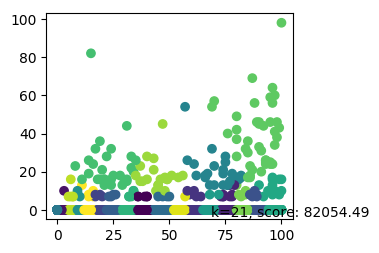

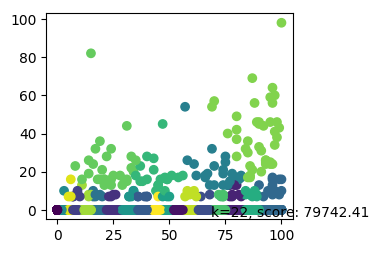

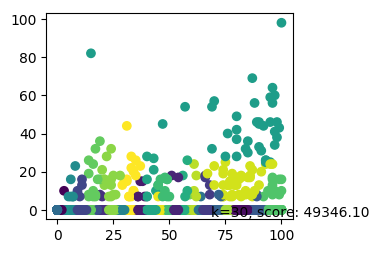

In [22]:
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
for index, k in enumerate((20,21,22,30)):
    fig = plt.figure(figsize=(7,6),dpi=100)
    plt.subplot(2,2,index+1)
    y_pred = MiniBatchKMeans(n_clusters=k, batch_size = 200, random_state=9).fit_predict(X)
    score= metrics.calinski_harabaz_score(X, y_pred)  
    plt.scatter(X[:, 0], X[:, 1], c=y_pred);
    plt.text(.99, .01, ('k=%d, score: %.2f' % (k,score)),
                 transform=plt.gca().transAxes, size=10,
                 horizontalalignment='center')
plt.show();

### 可见，k=21的时候，聚类效果最优

93295.90184705383

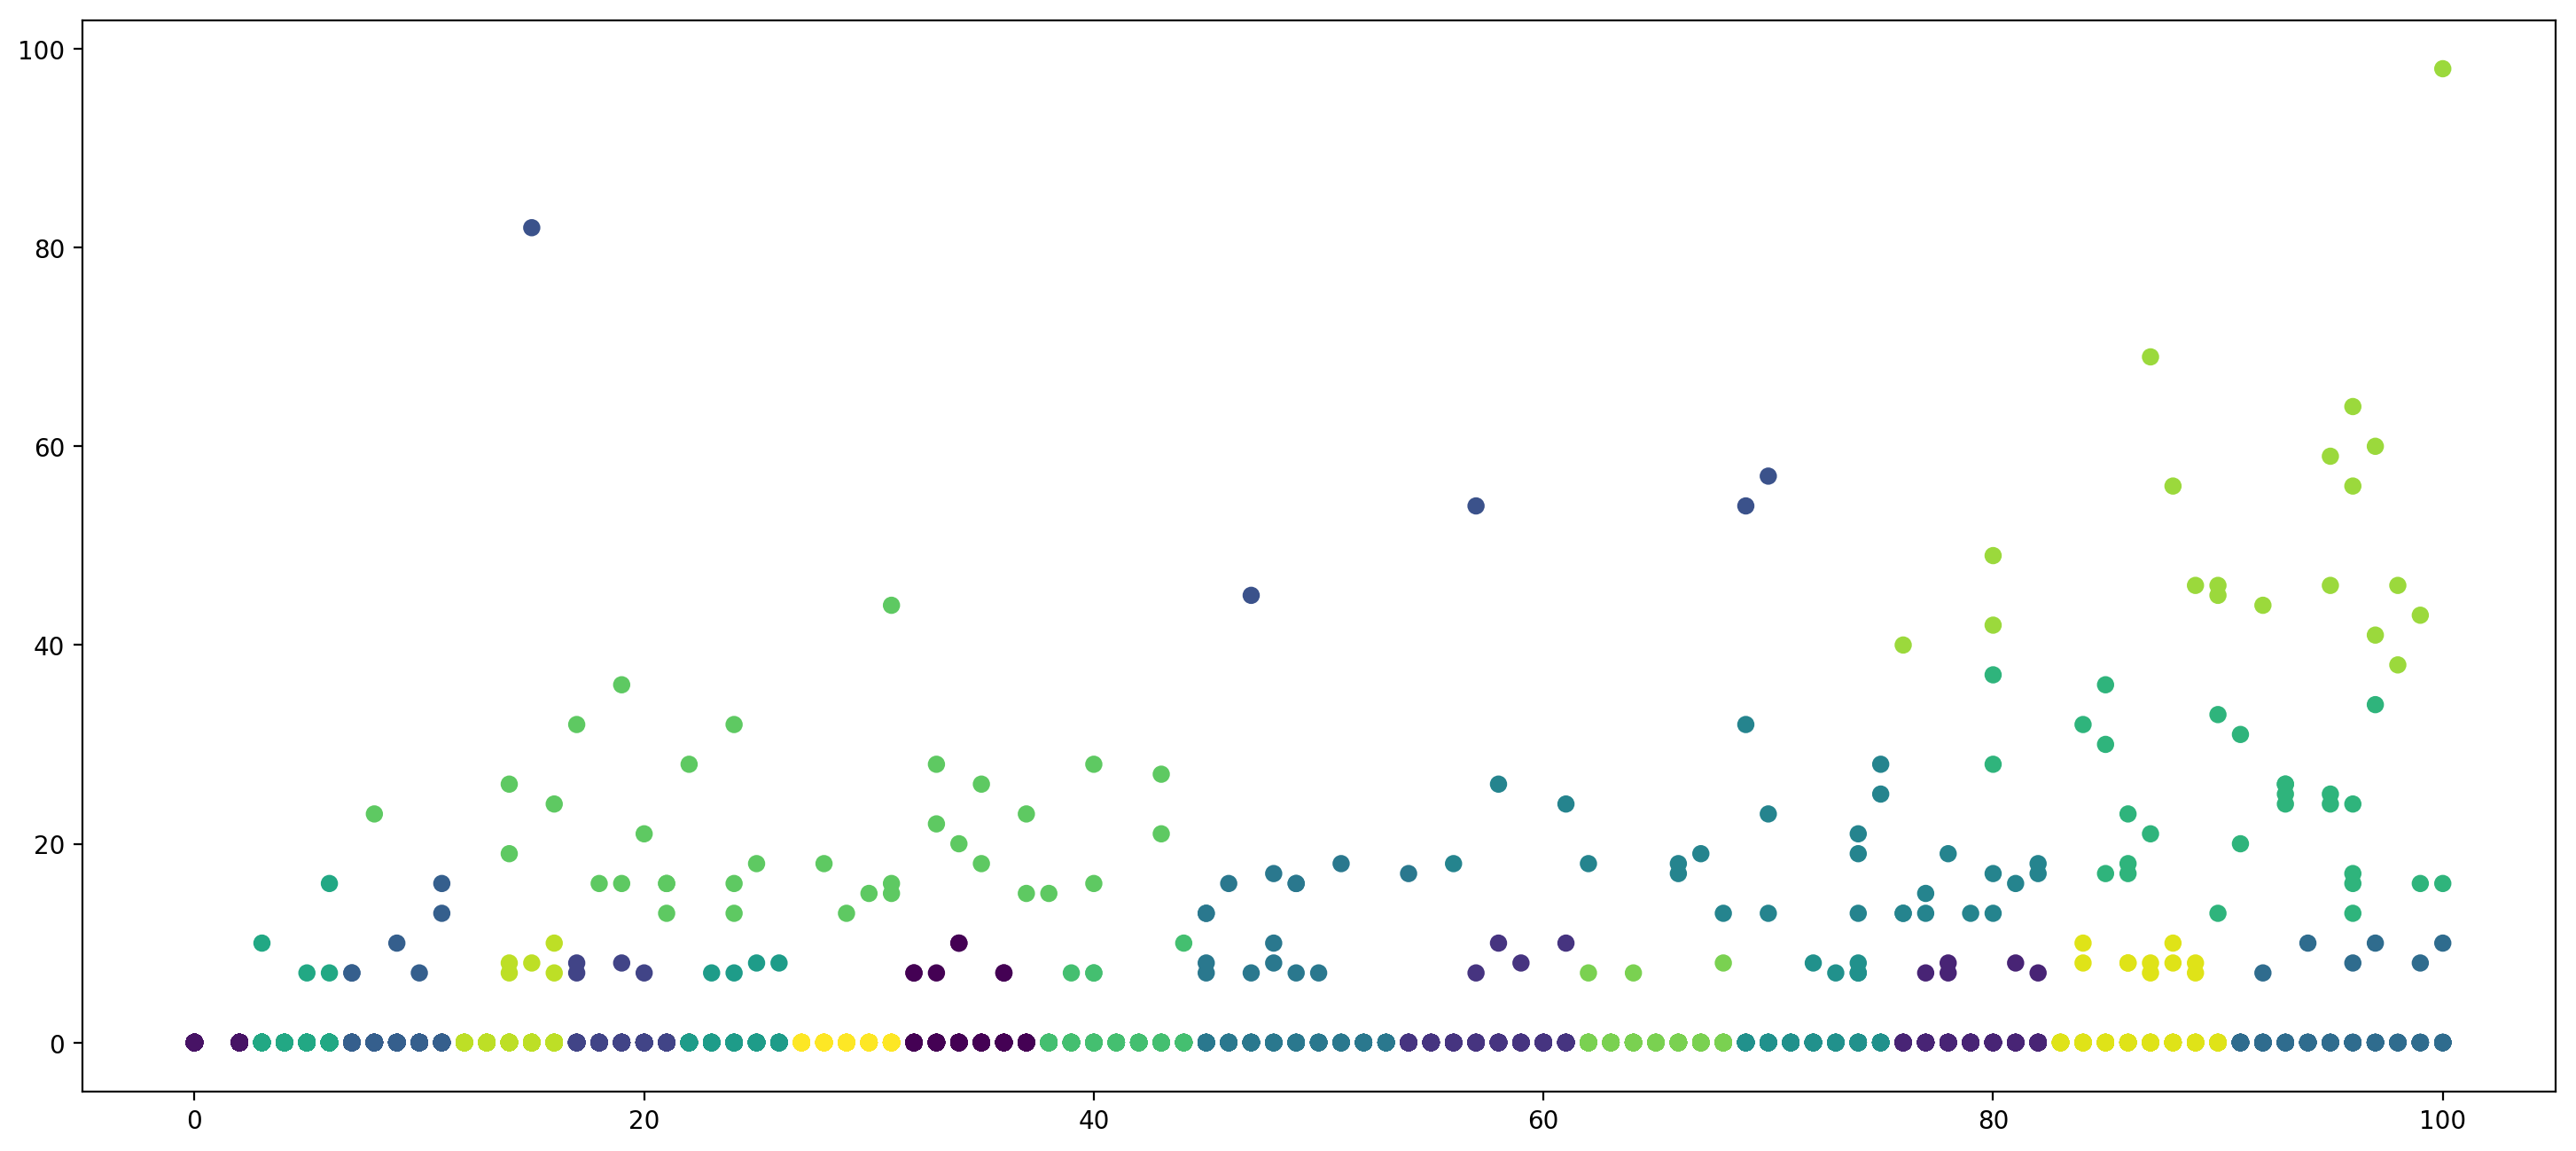

In [29]:
y_pred = KMeans(n_clusters=21, random_state=9).fit_predict(X)
fig = plt.figure(figsize=(18,8),dpi=200)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
from sklearn import metrics
metrics.calinski_harabaz_score(X, y_pred)  

## Mean Shift

number of estimated clusters : 15
18694.83851706305


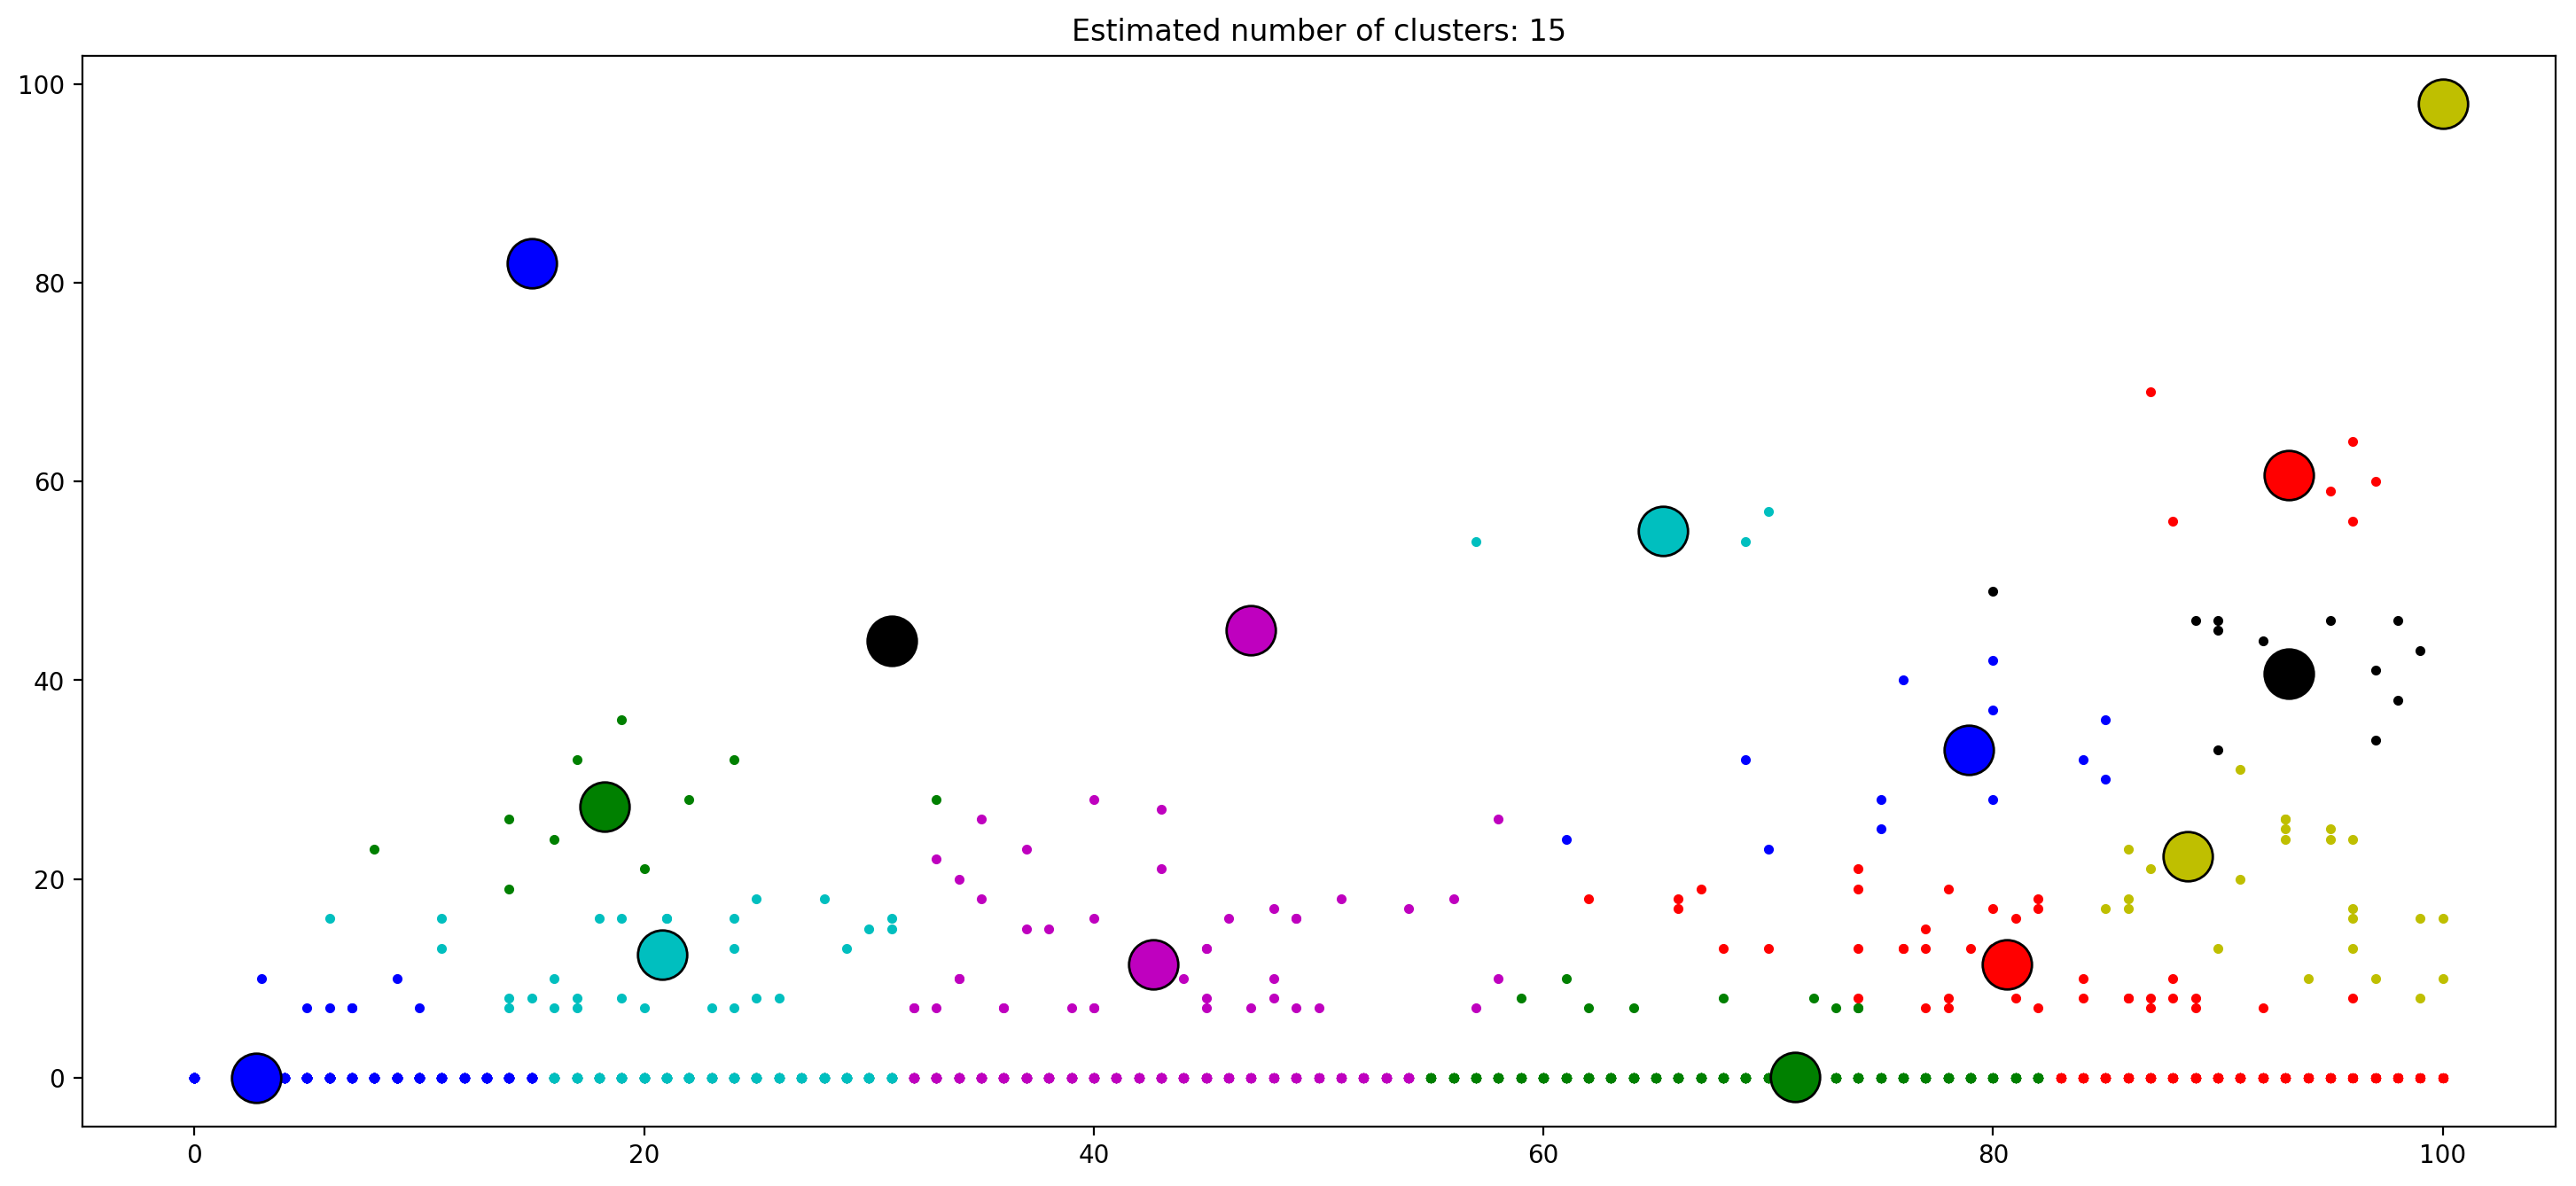

In [19]:
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=1000)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
y_pred = ms.fit_predict(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)
print(metrics.calinski_harabaz_score(X, y_pred) )
# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(figsize=(18,8),dpi=200)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=20)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show();

### 聚类初步分析

,play_passion,pay_passion,cluster
cluster,,,
7,94.411765,0.239819,221
17,91.736842,52.000000,19
13,90.666667,23.777778,27
19,86.654545,0.298182,275
2,79.025157,0.116352,318
9,72.333333,18.296296,27
10,71.863372,0.107558,344
16,65.021978,0.060440,364
3,57.684971,0.101156,346


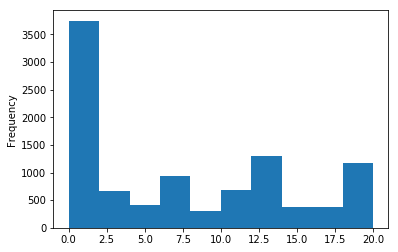

In [75]:
kmeans = KMeans(n_clusters=21, random_state=9).fit(X)
# kmeans.cluster_centers_
cluster = kmeans.labels_.tolist()
data['cluster'] = cluster
data['cluster'].plot(kind='hist')
a = data[['play_passion','pay_passion']].groupby(data['cluster']).mean()
b = pd.DataFrame(data['cluster'].value_counts())
a.join(b).sort_values(by='play_passion',ascending=False)

### 可见聚类效果还不错，也比较符合预期的分布
### 接下来，我们按照这个数据，再提取一些用户的基本信息进一步分析
用户注册信息：  
* 注册时所使用的IP地址 ip
* 账户类型 entrance_id
* 游戏版本号 version_info
* 渠道ID channel_code
* 广告激活ID ad_code
* 移动终端设备机型 m_dtype
* 操作系统 m_os
* 网络 m_network
* 城市 city
* 用户所在位置的纬度 latitude
* 用户所在位置的经度 longitude
* 代理商UID partner_info
* 推广员 promoter
* 设备CPU型号 cpu_type
* 是否有分享key is_share

In [76]:
# 保持模型数据
data.to_csv('./cluster_result.csv',index=False)

In [46]:
# 读取注册信息
columns = ["fbpid","fuid","signup_date","play_passion","pay_passion","cluster","fip_province","fpartner_info","fshare_key","fterminaltypename","fversionname","fm_imei","fchannel_code","fentrance_id","fad_code"]
signup_data = pd.read_csv('./query-hive-16214.csv',skiprows=2,names=columns)
signup_data.head(10)

,fbpid,fuid,signup_date,play_passion,pay_passion,cluster,fip_province,fpartner_info,fshare_key,fterminaltypename,fversionname,fm_imei,fchannel_code,fentrance_id,fad_code
0,384C601DAA0369E7BB9AECC1D53D3437,1002950932,2018-05-16,0,0,1,香港,0,login31f24550574663a8706f513a61708fbe,IOS,IPHONE,291981dd6f0ef58a4c5aa35ca5ab0d91,NaN,12,NaN
1,384C601DAA0369E7BB9AECC1D53D3437,1002950066,2018-05-15,2,0,1,香港,0,login9b2c1f797aabedc61ece096be8a233e3,IOS,IPHONE,617c0fad51a46a364bc2de6633133537,NaN,1,NaN
2,BD5FDCFA71A9CD5313766DAE14B56F9F,1002966233,2018-05-23,3,0,12,香港,0,login009aab71dbb31336b4fad1df4c6e22be,ANDROID,主版本,8e89584edb76009732b0c5c4d1c89d5e,115365.0,12,NaN
3,384C601DAA0369E7BB9AECC1D53D3437,1002951096,2018-05-16,5,0,12,香港,0,login581e9ffd86dc68a7f7baf5689b6aaa49,IOS,IPHONE,162db7e8a2180e951b321dcd67b4df0f,NaN,12,NaN
4,BD5FDCFA71A9CD5313766DAE14B56F9F,1002950938,2018-05-16,37,0,0,香港,0,login3a153e93c16f11ab80e8cd3f2810349d,ANDROID,主版本,7c3d072e2b636696347b807a9b3fa012,115365.0,12,NaN
5,BD5FDCFA71A9CD5313766DAE14B56F9F,1002965518,2018-05-23,0,0,1,香港,0,logine50a889d9b3b38ae3dc52bff863608e2,ANDROID,主版本,49a31bcb67773d84aea94bd92be7d73e,115365.0,12,NaN
6,384C601DAA0369E7BB9AECC1D53D3437,1002965099,2018-05-23,0,0,1,香港,0,login222a6843a0d5601d03250c70bfa6570b,IOS,IPHONE,b1acb6f0bf479076508d563381ab4732,NaN,12,NaN
7,BD5FDCFA71A9CD5313766DAE14B56F9F,1002965912,2018-05-23,8,0,6,香港,0,login206406e3381455489739e11d52967823,ANDROID,主版本,c66ea7b16b59dbfe210687a9efc3a4dd,115365.0,1,NaN
8,BD5FDCFA71A9CD5313766DAE14B56F9F,1002965244,2018-05-23,12,0,18,香港,0,loginc9f04784d90067d2e658e3038aa31566,ANDROID,主版本,781e3149261f5ccaa55bea4a10ea5c6d,115365.0,12,NaN
9,BD5FDCFA71A9CD5313766DAE14B56F9F,1002961208,2018-05-21,81,0,2,香港,0,login07b4aa1715e948fba3fba094d208a374,ANDROID,主版本,743d3d4ea884ff2b686d62343e21f670,115365.0,12,NaN


In [104]:
fiona_null = signup_data.shape[0] - signup_data.count()
fiona_null_percent = (fiona_null/signup_data.shape[0])
fiona_null_percent

fbpid                0.000000
fuid                 0.000000
signup_date          0.000000
play_passion         0.000000
pay_passion          0.000000
cluster              0.000000
fip_province         0.000000
fpartner_info        0.000000
fshare_key           0.000000
fterminaltypename    0.000000
fversionname         0.000000
fm_imei              0.000900
fchannel_code        0.471853
fentrance_id         0.000000
fad_code             0.994301
dtype: float64

In [117]:
high_score_users = signup_data.loc[(signup_data['cluster'] == 7)|(signup_data['cluster'] == 17)|(signup_data['cluster'] == 5)]

In [125]:
pd.pivot_table(high_score_users,index=['cluster'],columns=['fterminaltypename'],values='fuid',aggfunc=[len])

len    
fterminaltypename ANDROID IOS
cluster                      
5                       1   4
7                     122  99
17                      5  14

In [123]:
pd.pivot_table(signup_data,index=['fshare_key'],values='fuid',aggfunc=len).sort_values(by='fuid',ascending=False)

,fuid
fshare_key,
login8265d0f0151c78f17f6c0f5009d7ed00,26
login6a16c2266718b853b2364b098378a54b,15
login59b3147685a7ad316832da1eee256fd3,11
login440f1fefa5f31107e6adaa9b0f9c0f0a,9
loginb15793115b8d7bb3a909768e9375dbeb,9
logincecd98101f06e83efeec635786134cab,8
login239bf55ae3744c12c17894b54de3eee5,5
loginb049e3a37c61bc0bbd7e7685a9e0ecd9,5
login2f46ffbaeea5e428126237c448a8c825,4


In [122]:
pd.pivot_table(high_score_users,index=['fshare_key'],values='fuid',aggfunc=len).sort_values(by='fuid')

,fuid
fshare_key,
login0177886debfd06c679fb2ae6be24417f,1
logina148ea0e24277b95c3a697705bc51456,1
logina1cc307e431bf229259dd576dbba1365,1
logina309d90108738483a5655965479bcc27,1
logina3fc230a4a73a31a32e527d81ed93a01,1
logina49a1efdbc99cdd46234ca8a788c9ed7,1
logina56ea740e3b2217d3541e9fa357ce380,1
logina616943a05f774dacddc67b8c72c39a8,1
logina71a90039d323a0832af36a2e423e9c5,1


In [62]:
pd.pivot_table(signup_data,index=['cluster'],columns=['fentrance_id'],values='fuid',aggfunc=[len])

len               
fentrance_id      1       12     13
cluster                            
0               87.0   181.0  114.0
1             1247.0  1531.0  587.0
2               63.0   173.0   82.0
3               84.0   160.0  102.0
4              102.0   191.0  116.0
5                NaN     3.0    2.0
6              183.0   340.0  184.0
7               44.0   108.0   69.0
8               67.0   135.0   82.0
9                3.0    15.0    9.0
10              80.0   172.0   92.0
11              86.0   155.0  107.0
12             373.0   602.0  302.0
13               4.0    18.0    5.0
14              72.0   164.0  111.0
15               4.0    18.0   13.0
16              84.0   163.0  117.0
17               2.0    11.0    6.0
18             148.0   249.0  180.0
19              55.0   131.0   89.0
20              78.0   145.0  101.0

In [85]:
pd.pivot_table(signup_data,index=['cluster'],columns=['fad_code'],values='fuid',aggfunc=len)
pd.pivot_table(signup_data,index=['cluster'],values=['play_passion','pay_passion']).sort_values(by='play_passion',ascending=False)

fad_code,11819.0,11823.0,11827.0,11850.0,11855.0
cluster,,,,,
1,27.0,4.0,9.0,1.0,1.0
3,1.0,NaN,NaN,NaN,NaN
4,NaN,NaN,1.0,NaN,NaN
6,NaN,NaN,3.0,NaN,NaN
8,1.0,NaN,NaN,NaN,NaN
11,NaN,NaN,1.0,NaN,NaN
12,1.0,NaN,2.0,NaN,NaN
14,1.0,NaN,NaN,NaN,NaN
15,NaN,NaN,1.0,NaN,NaN


,pay_passion,play_passion
cluster,,
7,0.239819,94.411765
17,52.000000,91.736842
13,23.777778,90.666667
19,0.298182,86.654545
2,0.116352,79.025157
9,18.296296,72.333333
10,0.107558,71.863372
16,0.060440,65.021978
3,0.101156,57.684971
